<a href="https://colab.research.google.com/github/deepak-ucfknight/Machine_Learning_Spring19/blob/master/Extending_keras_network_with_connected_component_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import headers

import keras
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from skimage import util 
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Input
from keras import layers
from keras import Model
import cv2

Using TensorFlow backend.


In [2]:
# load mnist dataset for finding connected components

(x_train, y_train), (x_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# converting grayscale images to binary via opencv

for i in range(len(x_train)):
    image = x_train[i]
    threshold = 127
    x_train[i] = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]
    

for i in range(len(x_test)):
    image = x_test[i]
    threshold = 127
    x_test[i] = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]

In [0]:
# data normalization

x_train = x_train / 255;
x_test  = x_test  / 255; 

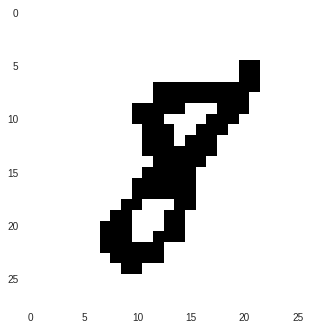

In [5]:
# image visualizer
image_to_visualize = 8
index = -1

for i in range(len(y_train)):
  if y_train[i] == image_to_visualize:
    index = i
    break;
    
inverted_img = (x_train[index])
plt.grid(None)
plt.imshow(inverted_img)

In [0]:
# creating vectors to hold connected component data - shape ( number of samples, 1)

connected_components_train = np.zeros_like(y_train)
connected_components_test  = np.zeros_like(y_test)

In [0]:
# using scipy ndimage to get connected components easily

for i in range(len(connected_components_train)):
  labeled, nr_objects = ndimage.label(util.invert(x_train[i]))
  connected_components_train[i] = nr_objects
  
for i in range(len(connected_components_test)):
  labeled, nr_objects = ndimage.label(util.invert(x_test[i]))
  connected_components_test[i] = nr_objects

In [0]:
# Manual recursive dfs search to find connected components -  this is very slow


# for i in range(len(connected_components_train)):
  
#   image = util.invert(x_train[i])
#   dx = [-1,0,1,1,1,0,-1,-1]
#   dy = [1,1,1,0,-1,-1,-1,0]
  
#   labelled = 1
  
#   labelled_image = np.zeros_like(image)
  
#   for row in range(len(image)):
#     for col in range(len(image[row])):
#         if image[row][col] ==  1 and labelled_image[row][col] == 0:
#             dfs(row, col, labelled)
#             labelled = labelled + 1
  
#   connected_components_train[i] = labelled - 1
  
  
  
# for i in range(len(connected_components_test)):
  
#   image = util.invert(x_test[i])
#   dx = [-1,0,1,1,1,0,-1,-1]
#   dy = [1,1,1,0,-1,-1,-1,0]
  
#   labelled = 1
  
#   labelled_image = np.zeros_like(image)
  
  
#   for row in range(len(image)):
#     for col in range(len(image[row])):
#         if image[row][col] ==  1 and labelled_image[row][col] == 0:
#             dfs(row, col, labelled)
#             labelled = labelled + 1
  
#   connected_components_test[i] = labelled - 1

# def dfs(x,y,c):
#     labelled_image[x][y] = c
#     for i in range(8):
#         nx = x+dx[i]
#         ny = y+dy[i]
#         if nx >= 0 and ny >= 0 and nx <28  and ny <28:
#             if image[nx][ny] == 1 and labelled_image[nx][ny] == 0:
#                 dfs(nx, ny, c)

In [0]:
# loading mnist dataset for training
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
# variables
rows = 28
cols = 28
num_classes = 10
batch_size = 32
input_dims = rows*cols
handcrafted_feature = 1

In [0]:
# converting dataset as per the backend format

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, rows, cols)
    x_test = x_test.reshape(x_test.shape[0], 1, rows, cols)
    input_shape = (1, rows, cols)
else:
    x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
    x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)
    input_shape = (rows, cols, 1)

# data normalization

x_train = x_train / 255;
x_test = x_test / 255;

connected_components_train = connected_components_train / 4
connected_components_test = connected_components_test / 4

# converting labels to categorical type

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# flattening the training data

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
y_train = y_train
y_test = y_test

In [13]:
# model 

# training data
input_shape = Input((input_dims,))

# hand crafed connected component feature
connected_component_feature = Input((handcrafted_feature,))

# fully connected layer with 64 neurons and sigmoid activation
image_vector = Dense(64, activation='sigmoid')(input_shape)

# concatenating handcrafted features and output of first dense layer
model_final  = layers.add([image_vector, connected_component_feature])   

# final fully connected layer with 10 neurons and softmax activation
model_final  = Dense(10, activation='softmax')(model_final)

# final model
model_final  = Model([input_shape, connected_component_feature], model_final)


Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# optimizer
sgd = optimizers.SGD(lr=0.1)

# compiling model
model_final.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# training the model
model_final.fit([x_train, connected_components_train], y_train, nb_epoch=20, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.5372 - acc: 0.8624
Epoch 2/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.2674 - acc: 0.9247
Epoch 3/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.2251 - acc: 0.9360
Epoch 4/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.1980 - acc: 0.9438
Epoch 5/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.1773 - acc: 0.9489
Epoch 6/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.1613 - acc: 0.9535
Epoch 7/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.1478 - acc: 0.9576
Epoch 8/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.1369 - acc: 0.9606
Epoch 9/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.1276 - acc: 0.9634
Epoch 10/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.1198 - acc: 0.9655

In [15]:
# model evaluation on test set
score = model_final.evaluate([x_test,connected_components_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]  * 100, "%")

Test score: 0.09317819482274353
Test accuracy: 97.14 %
